In [1]:
#Подключение необходимых библиотек
import cv2 as cv
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

In [2]:
#Эталонные последовательности цветов фишек, упорядоченные по их номерам
patterns = ['YBRBRY',
            'RBYYBR',
            'BBYYRR',
            'YBYRBR',
            'BRYYRB',
            'RYRBYB',
            'BYRYRB',
            'BRYRYB',
            'YRYBRB',
            'YRBRBY']

#Вспомогательные функции
def match_pattern(p):
  min_diff = 6
  arg_min = -1
  for i in range(len(patterns)):
    for j in range(6):
      t = patterns[i][j:] + patterns[i][:j]
      diff = sum(t[k] != p[k] for k in range(6))
      if diff < min_diff:
        min_diff = diff
        arg_min = i
  return arg_min

#Преобразование BGR -> RGB
def convert(img):
  return cv.merge([img[..., 2], img[..., 1], img[...,0]])

In [6]:
#Путь к изображению для распознавания
DATA = 'Образцы/Group_5.bmp'

#Константы, отвечающие за вывод промежуточных результатов
SHOW_CONTOURS = False
SHOW_HEXAGONES = False
SHOW_BOUNDING_BOXES = False

#Нужно ли сохранять результат
SAVE = False

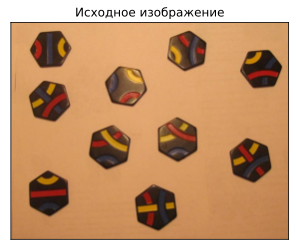

In [7]:
#Чтение картинки
img = cv.imread(DATA)
plt.imshow(convert(img))
plt.title("Исходное изображение")
plt.xticks([]), plt.yticks([])
plt.show()

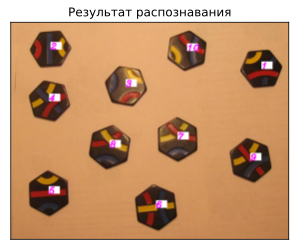

In [9]:
#Предобработка и выделение контуров
img = cv.imread(DATA)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
adjusted = cv.convertScaleAbs(gray, alpha=2, beta=30)
ret,th1 = cv.threshold(adjusted, 250, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(th1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
if SHOW_CONTOURS:
  cv.drawContours(img, contours, -1, (255,0,0), 2)
  plt.imshow(convert(img))
  plt.title("Найденные контуры")
  plt.xticks([]), plt.yticks([])
  plt.show()


#Сегментация
hexagones = []
lens = np.array(list(map(lambda x: cv.arcLength(x, True), contours)))
j = hierarchy[0][np.argmax(lens)][2]
while j >= 0:
  hull = cv.convexHull(contours[j])
  p = cv.arcLength(hull, True)
  c = 0.025
  if p < 200:
    j = hierarchy[0][j][0]
    continue
  angles = cv.approxPolyDP(hull, c * p, True)
  while (angles.shape[0] > 6):
    c += 0.005
    angles = cv.approxPolyDP(hull, c * p, True)
  cv.drawContours(img, [angles], 0, (0,255,255), 3)
  hexagones.append(angles)
  j = hierarchy[0][j][0]

centers = []
for hexagon in hexagones:
  c_1 = int(np.mean(hexagon[:, 0, 0]))
  c_2 = int(np.mean(hexagon[:, 0, 1]))
  centers.append((c_1, c_2))
  cv.circle(img, (c_1, c_2), 5, (0, 255, 0), 2)
if SHOW_HEXAGONES:
  plt.imshow(convert(img))
  plt.title("Шестиугольники и их центры")
  plt.xticks([]), plt.yticks([])
  plt.show()

bounding_boxes = []
for hexagon in hexagones:
  x,y,w,h = cv.boundingRect(hexagon)
  bounding_boxes.append((x, y, w, h))
  cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
if SHOW_BOUNDING_BOXES:
  plt.imshow(convert(img))
  plt.title("Bounding boxes")
  plt.xticks([]), plt.yticks([])
  plt.show()

#Классификация
img = cv.imread(DATA)
ans_img = cv.imread(DATA)
for j, hexagon in enumerate(hexagones):
  x, y, w, h = bounding_boxes[j]
  hex = img[y:(y+h), x:(x+w), :]
  pattern = ""
  #blue
  hsv = cv.cvtColor(hex, cv.COLOR_BGR2HSV)
  hsv_min = np.array((74, 0, 0), np.uint8)
  hsv_max = np.array((183, 75, 255), np.uint8)
  thresh = cv.inRange(hsv, hsv_min, hsv_max)
  b = hex[..., 0]
  b = cv.convertScaleAbs(b, alpha=4, beta=-10)
  b = cv.threshold(b ,np.mean(b),255,cv.THRESH_BINARY)[1]
  output = cv.connectedComponents(b, 8, cv.CV_32S)
  labels = output[1]
  num_labels = output[0]
  g = np.zeros_like(b, np.uint8)
  for k in range(num_labels):
    if np.sum((labels == k) * thresh) > np.sum(thresh) * 0.3:
      g += ((labels == k) * 255).astype(np.uint8)

  #yellow
  ye = hex[..., 1]
  yet = cv.threshold(ye, np.mean(ye.ravel()) + 30, 255, cv.THRESH_BINARY)[1]
  kernel = np.ones((5,5), np.uint8)
  yet = cv.morphologyEx(yet, cv.MORPH_OPEN, kernel)

  #red
  r = hex[..., 2] - hex[..., 1]
  rt = cv.threshold(r, int(np.mean(r.ravel()) * 1.8), 255, cv.THRESH_BINARY)[1]
  rt = cv.morphologyEx(rt, cv.MORPH_OPEN, kernel)
  for i in range(6):
    mask = np.zeros(img.shape)
    mid_1 = (hexagon[i, 0, 0] + hexagon[(i + 1) % 6, 0, 0]) // 2
    mid_2 = (hexagon[i, 0, 1] + hexagon[(i + 1) % 6, 0, 1]) // 2
    l = (int(centers[j][0] + (centers[j][0] - mid_1) * 0.8), int(centers[j][1] + (centers[j][1] - mid_2) * 0.8))
    cv.circle(mask, l, 5, (255, 255, 255), -1)
    mask = mask[y: (y + h), x: (x + w), 0]
  
    blue = np.sum(g * mask)
    yellow = np.sum(mask * yet)
    red = np.sum(mask * rt)

    ans = max(blue, yellow, red)
    if ans == blue:
      pattern += "B"
    elif ans == red:
      pattern += "R"
    else:
      pattern += "Y"
  cv.rectangle(ans_img, (x + w // 2, y + h // 2), (x + w // 2 + 30, y + h // 2 - 20), (255, 255, 255), -1)
  cv.putText(ans_img, str(match_pattern(pattern) + 1), (x + w // 2, y + h // 2),
             cv.FONT_HERSHEY_SCRIPT_COMPLEX, 0.8, (255, 0, 255),thickness=2)
plt.imshow(convert(ans_img))
plt.title("Результат распознавания")
plt.xticks([]), plt.yticks([])
if SAVE:
  plt.savefig("Result.jpg")
plt.show()